# Import Library

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [52]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
from wordcloud import WordCloud
from collections import Counter

In [54]:
import pickle

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [56]:
file_path = '/content/drive/MyDrive/Final-Project-Fake-News-Classification/news.csv'
df = pd.read_csv(file_path)
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


Dataset Terdiri dari 6335 baris dan 4 kolom: 'Unnamed: 0', 'title', 'text', dan 'label'.
Kolom 'Unnamed: 0' terlihat seperti indeks atau ID.
Kolom 'title' dan 'text' berisi teks berita.
Kolom 'label' berisi kelas target, yaitu 'FAKE' atau 'REAL'.

# EDA

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [58]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [59]:
# 1. cek missing value
df.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


tidak ada missing value di semua kolom

In [60]:
# 2. cek duplikasi data
df.duplicated().sum()

np.int64(0)

tidak ada data duplikat dalam seluruh DataFrame


Label Distribution:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


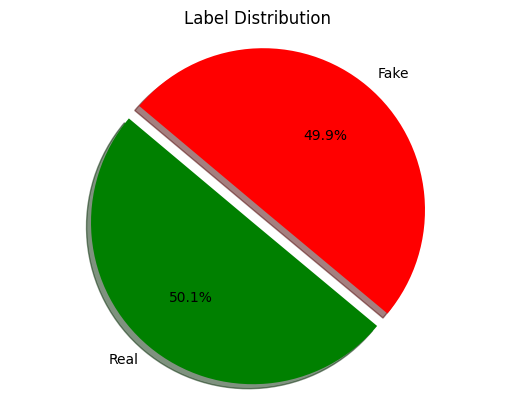

In [61]:
# 3. distribusi dalam pie chart
print("\nLabel Distribution:")
print(df['label'].value_counts())
labels = df['label'].value_counts()
colors = ['green', 'red']
explode = (0.1, 0)
plt.pie(labels, labels=['Real', 'Fake'], colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()

Distribusi label dalam dataset sangat seimbang. Hampir separuh data diklasifikasikan sebagai berita asli dan separuhnya lagi sebagai berita palsu.Keseimbangan label ini positif untuk pelatihan model klasifikasi karena model tidak akan bias terhadap kelas mayoritas. Akurasi yang baik pada dataset ini kemungkinan besar mencerminkan kemampuan model dalam memprediksi kedua kelas dengan baik.

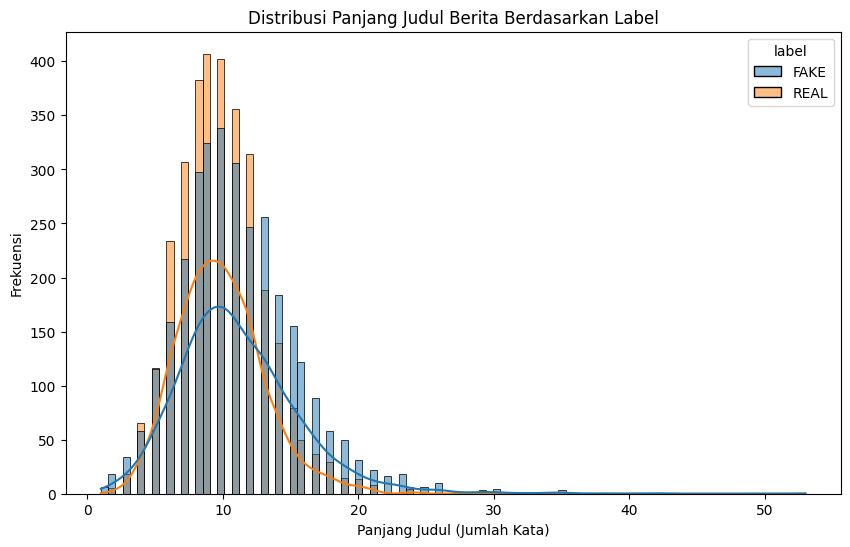

In [62]:
# 4. Panjang Jusul Berita
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='title_length', hue='label', kde=True)
plt.title('Distribusi Panjang Judul Berita Berdasarkan Label')
plt.xlabel('Panjang Judul (Jumlah Kata)')
plt.ylabel('Frekuensi')
plt.show()

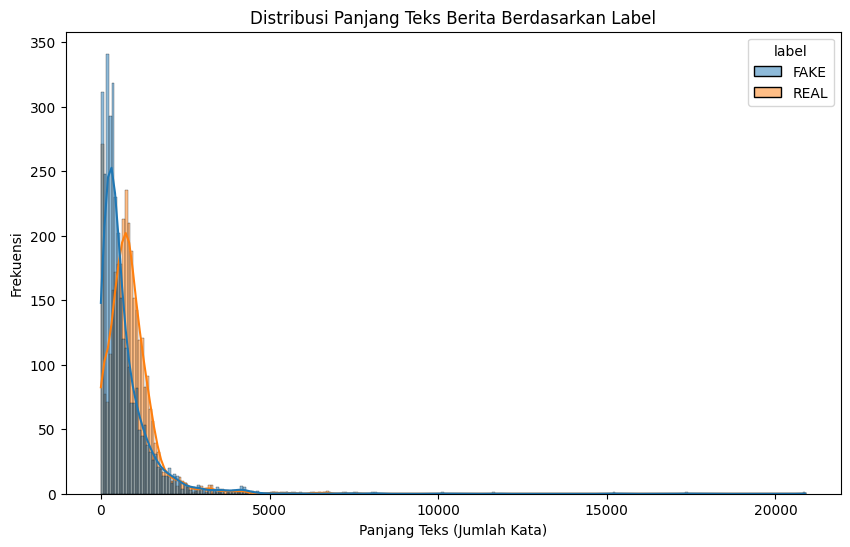

In [63]:
# 5. Panjang Teks Berita
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', kde=True)
plt.title('Distribusi Panjang Teks Berita Berdasarkan Label')
plt.xlabel('Panjang Teks (Jumlah Kata)')
plt.ylabel('Frekuensi')
plt.show()

Distribusi panjang teks untuk kedua label menunjukkan perbedaan yang lebih jelas dibandingkan dengan panjang judul. Berita 'REAL' cenderung memiliki distribusi yang lebih lebar dan memanjang ke arah teks yang lebih panjang. Sementara itu, berita 'FAKE' cenderung terkonsentrasi pada panjang teks yang lebih pendek.

In [64]:
# 1. Statistik Deskriptif Panjang Teks Berdasarkan Label
print("\nStatistik Deskriptif Panjang Teks Berita:")
print(df.groupby('label')['text_length'].describe())


Statistik Deskriptif Panjang Teks Berita:
        count        mean         std  min    25%    50%     75%      max
label                                                                    
FAKE   3164.0  679.129267  958.962790  0.0  212.0  421.0   830.0  20891.0
REAL   3171.0  873.257647  722.483569  7.0  450.5  771.0  1123.0   7602.0


1. Mean: Rata-rata panjang teks berita 'REAL' (sekitar 873 kata) jauh lebih tinggi dibandingkan dengan berita 'FAKE' (sekitar 679 kata).
2. Std: Standar deviasi panjang teks berita 'FAKE' (sekitar 959) juga lebih tinggi dibandingkan 'REAL' (sekitar 722), menunjukkan variasi panjang teks yang lebih besar dalam berita palsu.
3. Min: Berita 'FAKE' memiliki teks dengan panjang minimum 0 kata (kemungkinan ada entri kosong atau kesalahan data yang perlu diselidiki lebih lanjut), sedangkan berita 'REAL' memiliki panjang minimum 7 kata.
4. Kuartil 25 50 75: Pada semua kuartil, panjang teks berita 'REAL' secara signifikan lebih tinggi dibandingkan dengan berita 'FAKE'. Median (50%) panjang teks berita 'REAL' adalah 771 kata, sedangkan untuk 'FAKE' hanya 421 kata.
5. Max: Berita 'FAKE' memiliki teks terpanjang yang jauh melampaui berita 'REAL' (20891 vs 7602 kata). Ini bisa jadi menunjukkan adanya jenis berita palsu yang sangat panjang dan detail.

In [65]:
zero_length_fake_news = df[(df['label'] == 'FAKE') & (df['text_length'] == 0)]
print("\nBerita Palsu dengan Panjang Teks 0:")
print(zero_length_fake_news)


Berita Palsu dengan Panjang Teks 0:
      Unnamed: 0                                              title text  \
106         5530  The Arcturian Group by Marilyn Raffaele Octobe...        
710         8332  MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...        
806         9314  Southern Poverty Law Center Targets Anti-Jihad...        
919        10304  Refugee Resettlement Watch: Swept Away In Nort...        
940         9474  Michael Bloomberg Names Technological Unemploy...        
1664        5802  Alert News : Putins Army Is Coming For World W...        
1736        9564  An LDS Reader Takes A Look At Trump Accuser Je...        
1851        5752  America’s Senator Jeff Sessions Warns of Worse...        
1883        8816  Paris Migrant Campers Increase after Calais Is...        
1941        7525  Putins Army is coming for World war 3 against ...        
2244        6714  Is your promising internet career over now Vin...        
2426        5776  Radio Derb Transcript For October

In [66]:
# cek ada berapa banyak dataset dengan panajng texk = 0
zero_length_fake_news.shape

(36, 6)

In [67]:
if not zero_length_fake_news.empty:
    print(f"\nJumlah berita palsu dengan panjang teks 0: {len(zero_length_fake_news)}")
    df = df.drop(zero_length_fake_news.index)
    df.reset_index(drop=True, inplace=True)
    print("\nBerita palsu dengan panjang teks 0 telah dihapus.")
else:
    print("\nTidak ada berita palsu dengan panjang teks 0 ditemukan.")

# Perbarui kembali kolom 'text_length' setelah penghapusan
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))


Jumlah berita palsu dengan panjang teks 0: 36

Berita palsu dengan panjang teks 0 telah dihapus.


In [68]:
# cek kembali ada berapa banyak dataset dengan panajng texk = 0
zero_length_fake_news = df[(df['label'] == 'FAKE') & (df['text_length'] == 0)]
print("\nBerita Palsu dengan Panjang Teks 0:")
print(zero_length_fake_news)


Berita Palsu dengan Panjang Teks 0:
Empty DataFrame
Columns: [Unnamed: 0, title, text, label, title_length, text_length]
Index: []


In [69]:
df.shape

(6299, 6)


Label Distribution:
label
REAL    3171
FAKE    3128
Name: count, dtype: int64


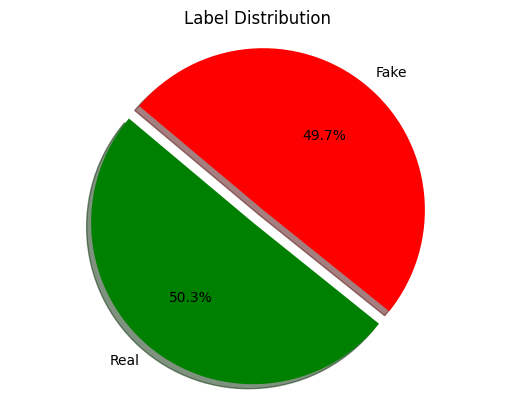

In [70]:
# 3. distribusi dalam pie chart
print("\nLabel Distribution:")
print(df['label'].value_counts())
labels = df['label'].value_counts()
colors = ['green', 'red']
explode = (0.1, 0)
plt.pie(labels, labels=['Real', 'Fake'], colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()

setelah menghapus beberapa dataset dengan panjang teks 0, distribusi label sedikit berubah. perubahan ada pada label FAKE, yang awalnya berjumlah 3164 menjadi 3128.

In [71]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

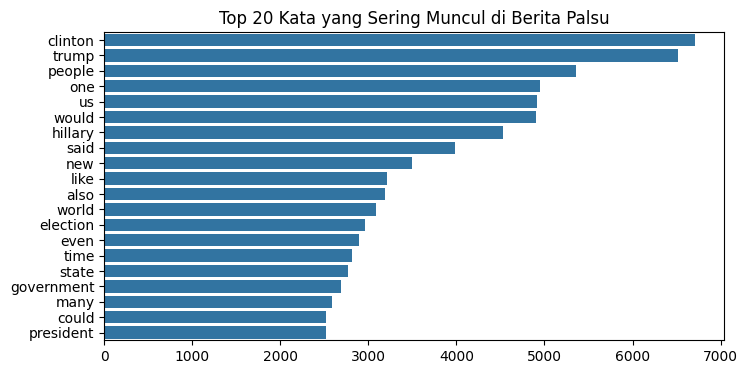

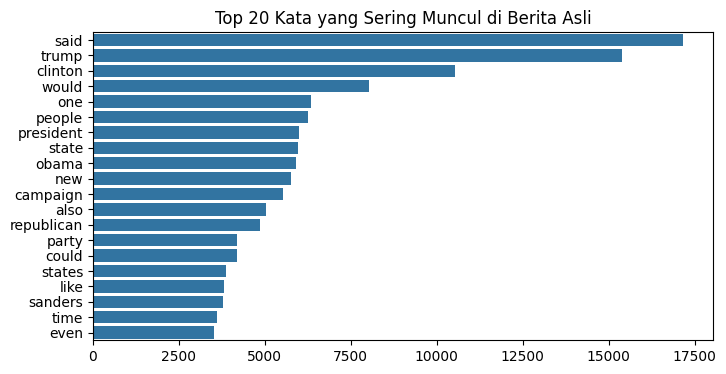

In [72]:
# 6. Kata-kata yang Sering Muncul (Sebelum Preprocessing Sederhana)
def plot_top_n_words(corpus, n=20, title='Top 20 Kata yang Sering Muncul'):
    token_dict = Counter()
    for text in corpus:
        if isinstance(text, str):
            for word in word_tokenize(text.lower()):
                if word.isalpha() and word not in stop_words:
                    token_dict[word] += 1
    top_words = token_dict.most_common(n)
    words, counts = zip(*top_words)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.show()

plot_top_n_words(df[df['label'] == 'FAKE']['text'], title='Top 20 Kata yang Sering Muncul di Berita Palsu')
plot_top_n_words(df[df['label'] == 'REAL']['text'], title='Top 20 Kata yang Sering Muncul di Berita Asli')

Barplot teks berita palsu: Bar chart yang menampilkan 20 kata paling sering muncul dalam teks berita yang berlabel 'FAKE'. Kata-kata seperti "clinton", "trump", "people", "one", "us" mendominasi. Kata-kata teratas menunjukkan fokus pada tokoh politik ("clinton", "trump"), kelompok ("people", "us"), dan kata-kata umum lainnya.

Bar chart berita asli: Bar chart yang menampilkan 20 kata paling sering muncul dalam teks berita yang berlabel 'REAL'. Kata-kata seperti "said", "trump", "clinton", "would", "one" muncul dengan frekuensi tinggi.Mirip dengan berita palsu, kata-kata teratas juga didominasi oleh tokoh politik ("trump", "clinton", "obama") dan kata-kata umum. Kata "said" muncul lebih tinggi dalam berita asli, yang mungkin mengindikasikan kutipan dan pelaporan faktual.

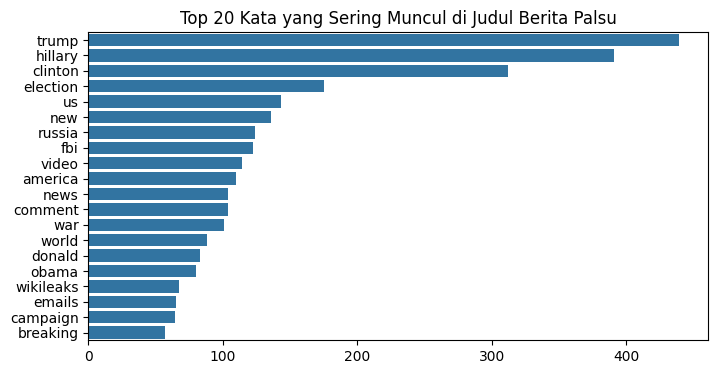

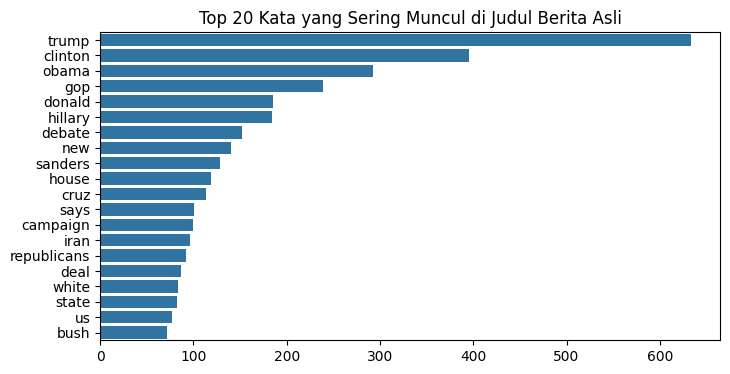

In [73]:
# 7. Kata-kata yang Sering Muncul di Judul
plot_top_n_words(df[df['label'] == 'FAKE']['title'].astype(str), title='Top 20 Kata yang Sering Muncul di Judul Berita Palsu')
plot_top_n_words(df[df['label'] == 'REAL']['title'].astype(str), title='Top 20 Kata yang Sering Muncul di Judul Berita Asli')

Meskipun topik politik umum muncul di kedua jenis judul, perbedaan dalam frekuensi dan keberadaan kata-kata spesifik (misalnya, "gop", "debate", "sanders") mungkin mencerminkan fokus berita yang berbeda atau gaya penulisan yang berbeda dalam menyampaikan informasi.

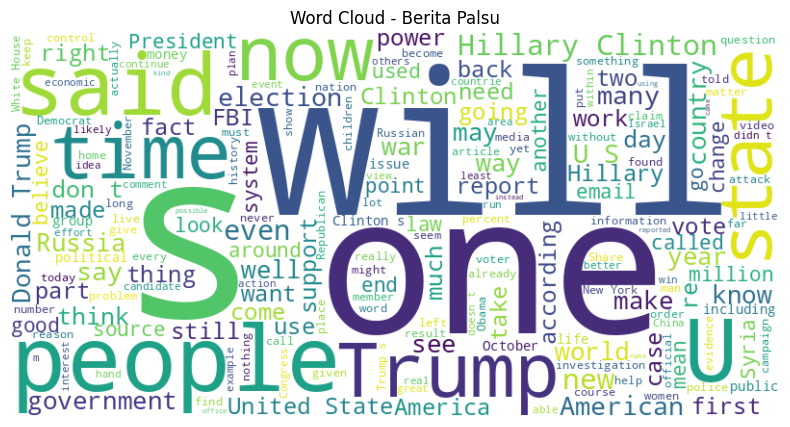

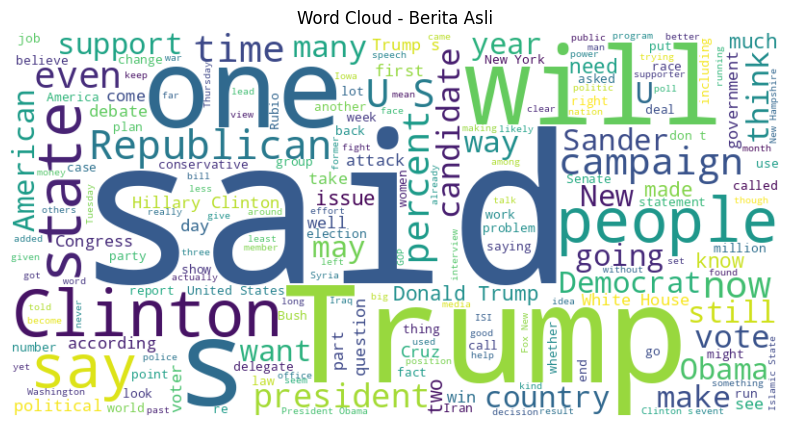

In [74]:
# 8. Word Cloud Isi Berita berdasarkan Label
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(df[df['label'] == 'FAKE']['text'].astype(str), 'Word Cloud - Berita Palsu')
generate_wordcloud(df[df['label'] == 'REAL']['text'].astype(str), 'Word Cloud - Berita Asli')

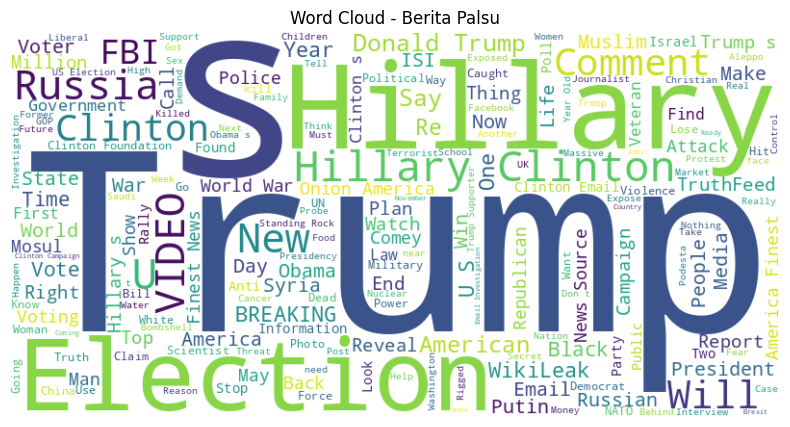

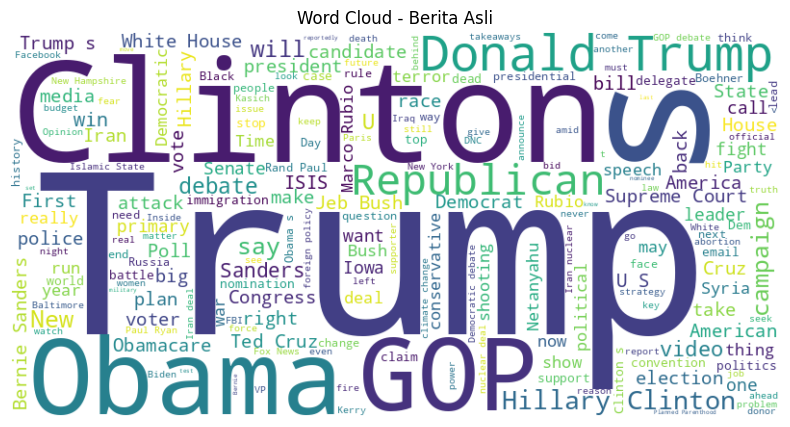

In [75]:
# 9. Word Cloud Judul Berita berdasarkan Label
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(df[df['label'] == 'FAKE']['title'].astype(str), 'Word Cloud - Berita Palsu')
generate_wordcloud(df[df['label'] == 'REAL']['title'].astype(str), 'Word Cloud - Berita Asli')

In [76]:
df.shape

(6299, 6)

# Preprocessing

In [77]:
# 1. Penghapusan Fitur yang Tidak Diperlukan
df = df.drop('Unnamed: 0', axis=1, errors='ignore')
print("Fitur 'Unnamed: 0' (jika ada) telah dihapus.")

Fitur 'Unnamed: 0' (jika ada) telah dihapus.


In [78]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [79]:
# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [80]:
# 2. Penggabungan Judul dan Teks
df['full_text'] = df['title'].astype(str) + ' ' + df['text'].astype(str)
df = df.drop(['title', 'text'], axis=1)
print("Fitur 'title' dan 'text' telah digabungkan menjadi 'full_text' dan dihapus.")

Fitur 'title' dan 'text' telah digabungkan menjadi 'full_text' dan dihapus.


In [81]:
def preprocess_text(text):
    if isinstance(text, str):
        # 3. Hapus Tanda Baca dan Karakter Spesial
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I)
        text = re.sub(r'\s+', ' ', text).strip()
        # 4. Konversi ke Huruf Kecil
        text = text.lower()

        # 5. Tokenisasi
        tokens = word_tokenize(text)

        # 6. Penghapusan Stopwords
        filtered_tokens = [w for w in tokens if w not in stop_words and w.isalpha()]
        return filtered_tokens
    return []

df['processed_tokens'] = df['full_text'].apply(preprocess_text)
df.drop('full_text', axis=1, inplace=True)
print("Teks telah diproses (tanda baca dihapus, lowercased, tokenized, stopwords dihapus).")

Teks telah diproses (tanda baca dihapus, lowercased, tokenized, stopwords dihapus).


In [82]:
df.head()

,label,title_length,text_length,processed_tokens
0,FAKE,5,1296,"[smell, hillarys, fear, daniel, greenfield, sh..."
1,FAKE,14,446,"[watch, exact, moment, paul, ryan, committed, ..."
2,REAL,9,431,"[kerry, go, paris, gesture, sympathy, us, secr..."
3,FAKE,15,404,"[bernie, supporters, twitter, erupt, anger, dn..."
4,REAL,9,317,"[battle, new, york, primary, matters, primary,..."


# Feature Engineering

In [83]:
#TF-IDF
df['processed_text_string'] = df['processed_tokens'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Batasi jumlah fitur untuk menghindari dimensi tinggi
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text_string'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())  # Membuat DataFrame dari matriks TF-IDF

df.reset_index(drop=True, inplace=True)
tfidf_df.reset_index(drop=True, inplace=True)

features_df = pd.concat([tfidf_df, df[['text_length']]], axis=1)

if 'title_length' in df.columns:
    features_df = pd.concat([features_df, df[['title_length']]], axis=1)

df['unique_word_count'] = df['processed_tokens'].apply(lambda x: len(set(x)))
features_df = pd.concat([features_df, df[['unique_word_count']]], axis=1)

df['label_encoded'] = df['label'].map({'FAKE': 0, 'REAL': 1})  # Create 'label_encoded' column
labels = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

print("Shape dari fitur training:", X_train.shape)
print("Shape dari fitur testing:", X_test.shape)
print("Shape dari target training:", y_train.shape)
print("Shape dari target testing:", y_test.shape)

print("\nBeberapa kolom fitur hasil TF-IDF:")
print(features_df.head())

Shape dari fitur training: (5039, 10003)
Shape dari fitur testing: (1260, 10003)
Shape dari target training: (5039,)
Shape dari target testing: (1260,)

Beberapa kolom fitur hasil TF-IDF:
   aaron  abaaoud  abandon  abandoned  abandoning  abbas  abbott       abc  \
0    0.0      0.0      0.0        0.0         0.0    0.0     0.0  0.000000   
1    0.0      0.0      0.0        0.0         0.0    0.0     0.0  0.065483   
2    0.0      0.0      0.0        0.0         0.0    0.0     0.0  0.000000   
3    0.0      0.0      0.0        0.0         0.0    0.0     0.0  0.000000   
4    0.0      0.0      0.0        0.0         0.0    0.0     0.0  0.000000   

   abcs  abdeslam  ...  zionism  zionist  zionists  zone  zones  zuckerberg  \
0   0.0       0.0  ...      0.0      0.0       0.0   0.0    0.0         0.0   
1   0.0       0.0  ...      0.0      0.0       0.0   0.0    0.0         0.0   
2   0.0       0.0  ...      0.0      0.0       0.0   0.0    0.0         0.0   
3   0.0       0.0  ...     

In [84]:
df.head()

,label,title_length,text_length,processed_tokens,processed_text_string,unique_word_count,label_encoded
0,FAKE,5,1296,"[smell, hillarys, fear, daniel, greenfield, sh...",smell hillarys fear daniel greenfield shillman...,438,0
1,FAKE,14,446,"[watch, exact, moment, paul, ryan, committed, ...",watch exact moment paul ryan committed politic...,203,0
2,REAL,9,431,"[kerry, go, paris, gesture, sympathy, us, secr...",kerry go paris gesture sympathy us secretary s...,179,1
3,FAKE,15,404,"[bernie, supporters, twitter, erupt, anger, dn...",bernie supporters twitter erupt anger dnc trie...,186,0
4,REAL,9,317,"[battle, new, york, primary, matters, primary,...",battle new york primary matters primary day ne...,125,1


In [85]:
# simpan tf-idf vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Modeling

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score


--- Logistic Regression ---
Accuracy: 0.9230158730158731
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       625
           1       0.94      0.91      0.92       635

    accuracy                           0.92      1260
   macro avg       0.92      0.92      0.92      1260
weighted avg       0.92      0.92      0.92      1260



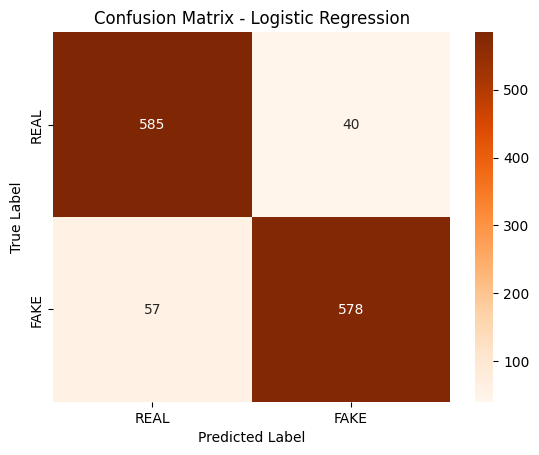

In [87]:
# Training model Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("Classification Report:\n", classification_report(y_test, lr_pred))
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

--- Random Forest ---
Accuracy: 0.9261904761904762
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       625
           1       0.93      0.92      0.93       635

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



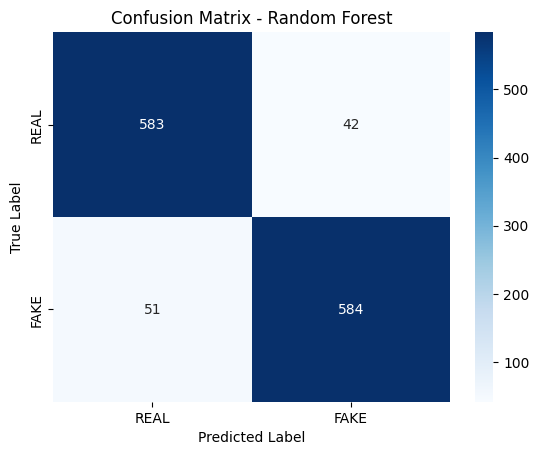

In [88]:
# Training model rendom Forest
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train) # Changed rf_model to random_forest_model
rf_pred = random_forest_model.predict(X_test) # Changed rf_model to random_forest_model
print("--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [89]:
# 1. Inisialisasi Model
logistic_model = LogisticRegression(random_state=42, solver='liblinear')

# 2. Pelatihan Model Awal
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [90]:
# 1. Inisialisasi Model
random_forest_model = RandomForestClassifier(random_state=42)

# 2. Pelatihan Model Awal
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluation Before Tuning

Evaluasi Model Logistic Regression:

Akurasi: 0.9230
F1-Score: 0.9226
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       625
           1       0.94      0.91      0.92       635

    accuracy                           0.92      1260
   macro avg       0.92      0.92      0.92      1260
weighted avg       0.92      0.92      0.92      1260



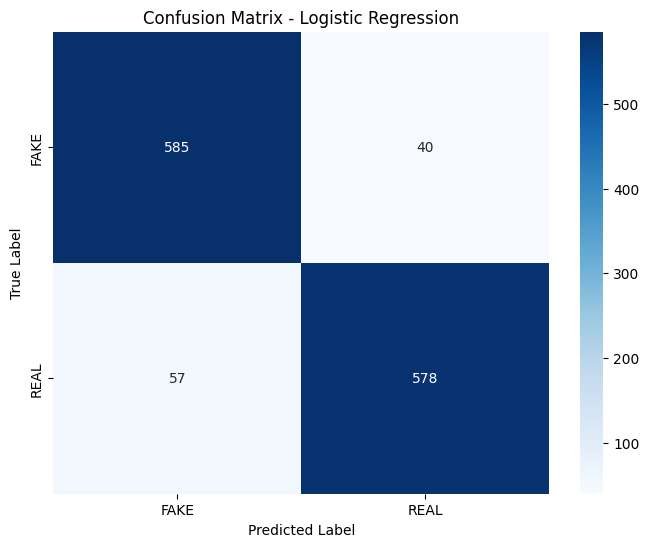

Evaluasi Model Random Forest:

Akurasi: 0.9262
F1-Score: 0.9262
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       625
           1       0.93      0.92      0.93       635

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



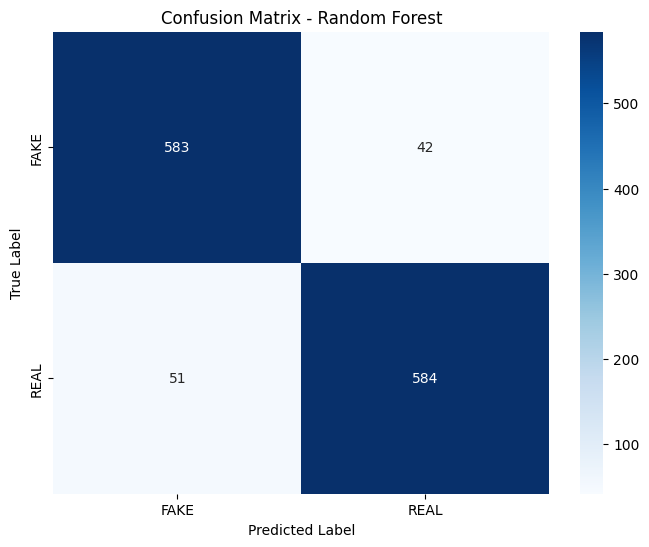

In [91]:
# 3. Evaluasi Model Awal
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Evaluasi Model {model_name}:\n")
    print(f"Akurasi: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Classification Report:\n", report)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return model, accuracy, f1, report, cm

logistic_model, lr_accuracy, lr_f1, lr_report, lr_cm = evaluate_model(logistic_model, X_test, y_test, "Logistic Regression")
random_forest_model, rf_accuracy, rf_f1, rf_report, rf_cm = evaluate_model(random_forest_model, X_test, y_test, "Random Forest")

# Hyperparameter Tuning

In [92]:
# 4. Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
# Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'),
                             param_grid_lr, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_
print("\nBest Hyperparameters for Logistic Regression:", grid_search_lr.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Hyperparameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}


In [93]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid_rf, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_
print("\nBest Hyperparameters for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


# Evaluation After Tuning

Evaluasi Model Logistic Regression (Tuned):

Akurasi: 0.9405
F1-Score: 0.9407
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       625
           1       0.94      0.94      0.94       635

    accuracy                           0.94      1260
   macro avg       0.94      0.94      0.94      1260
weighted avg       0.94      0.94      0.94      1260



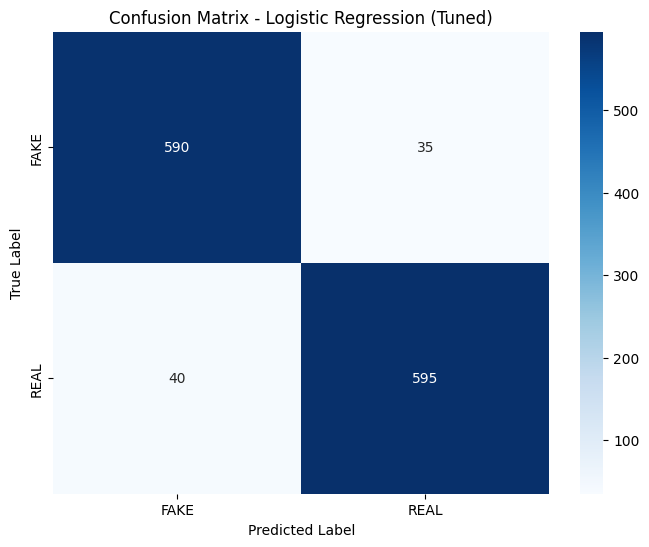

Evaluasi Model Random Forest (Tuned):

Akurasi: 0.9159
F1-Score: 0.9164
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       625
           1       0.92      0.91      0.92       635

    accuracy                           0.92      1260
   macro avg       0.92      0.92      0.92      1260
weighted avg       0.92      0.92      0.92      1260



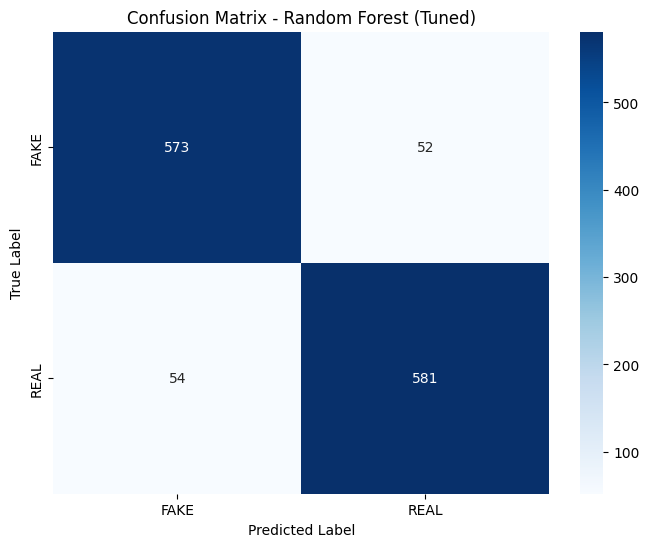

In [94]:
# 5. Evaluasi Model Setelah Tuning
best_logistic_model, best_lr_accuracy, best_lr_f1, best_lr_report, best_lr_cm = evaluate_model(best_lr_model, X_test, y_test, "Logistic Regression (Tuned)")
best_random_forest_model, best_rf_accuracy, best_rf_f1, best_rf_report, best_rf_cm = evaluate_model(best_rf_model, X_test, y_test, "Random Forest (Tuned)")

In [95]:
# 6. Pemilihan Model Terbaik
print("\nPerbandingan Model Terbaik:")
print(f"Logistic Regression (Tuned) - Akurasi: {best_lr_accuracy:.4f}, F1-Score: {best_lr_f1:.4f}")
print(f"Random Forest (Tuned) - Akurasi: {best_rf_accuracy:.4f}, F1-Score: {best_rf_f1:.4f}")

if best_lr_f1 > best_rf_f1:
    best_model = best_logistic_model
    best_model_name = "Logistic Regression"
else:
    best_model = best_random_forest_model
    best_model_name = "Random Forest"

print(f"\nModel Terbaik yang Dipilih: {best_model_name}")


Perbandingan Model Terbaik:
Logistic Regression (Tuned) - Akurasi: 0.9405, F1-Score: 0.9407
Random Forest (Tuned) - Akurasi: 0.9159, F1-Score: 0.9164

Model Terbaik yang Dipilih: Logistic Regression


# Saved Model

In [96]:
# save model
import pickle
with open('LR_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Interpretation

In [97]:
# 7. Interpretasi Model (Contoh untuk Logistic Regression)
if best_model_name == "Logistic Regression":
    feature_names = X_train.columns
    coefficients = best_model.coef_[0]
    feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)
    print("\nTop 10 Fitur Penting (Logistic Regression):")
    for feature, importance in feature_importance[:10]:
        print(f"{feature}: {importance:.4f}")


Top 10 Fitur Penting (Logistic Regression):
october: -11.1035
said: 11.0739
november: -6.8268
hillary: -6.3439
gop: 6.1816
article: -6.1016
candidates: 5.5571
islamic: 5.3650
share: -5.3452
thats: 5.0969


In [2]:
pip freeze > requirements.txt